In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns

* Make new 'feature' visual search stimuli datasets with differing discriminability of target and distractors
  > 'Feature' search is red vertical rectangle target v. green vertical rectangle distractors.
Here the red and green are both moved closer to yellow, e.g. for the value of 51 the "red" target's RGB color is `[255 51 0]` while the "green" distractor is `[51 255 0]`. Since `[255 255 0]` is yellow, both the target and distractor colors are being shifted closer to yellow, but from opposite directions.

* Use new datasets with different target-distractor discriminabilities to get accuracy of neural networks previously trained on this 'feature' visual search task

In [2]:
D_RANGE = np.linspace(0,1,1000)

In [3]:
# chance = 0.5  # between 0 and 1
# y = chance + (1-chance) / (1 + np.exp(-k*(x-x0)))

def psychometric_func(x, alpha, beta, chance=0.5):
    """psychometric function"""
    return chance + (1-chance) / (1 + np.exp( -(x - alpha) / beta) )

In [4]:
def inspect_fits(fits_source_df,
                 fits_df,
                 net_name,
                 method,
                 source_dataset,
                 d_range=D_RANGE,
                 figsize=(12, 4),
                 ylim=(0.4, 1.05),
                 axes_title=True,
                 suptitle=True,
                 xylabel=True,
                ):
    this_fits_source_df = fits_source_df[
        (fits_source_df.net_name == net_name) &
        (fits_source_df.method == method) & 
        (fits_source_df.source_dataset == source_dataset)       
    ]
    this_fits_df = fits_df[
        (fits_df.net_name == net_name) &
        (fits_df.method == method) & 
        (fits_df.source_dataset == source_dataset)
    ]
    
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    ax = ax.ravel()

    for set_size_ind, set_size in enumerate(this_fits_df.set_size.unique()):
        source_set_size_df = this_fits_source_df[
            this_fits_source_df.set_size == set_size
        ]
        fits_set_size_df = this_fits_df[
            this_fits_df.set_size == set_size
        ]

        for net_number_ind, net_number in enumerate(source_set_size_df.net_number.unique()):
            source_net_num_df = source_set_size_df[
                source_set_size_df.net_number == net_number
            ]
            fits_net_num_df = fits_set_size_df[
                fits_set_size_df.net_number == net_number
            ]

            discrim_pct = source_net_num_df.discrim_pct.values
            acc = source_net_num_df.accuracy.values
            ax[set_size_ind].plot(discrim_pct, acc, marker='o', linestyle='None')

            ax[set_size_ind].plot(fits_net_num_df['discrim_threshold'], 
                                  fits_net_num_df['threshold_acc'], 
                                  marker='x',
                                  linestyle='None')
            
            ax[set_size_ind].plot(d_range, 
                                  psychometric_func(d_range, 
                                                    fits_net_num_df.alpha.values.item(),
                                                    fits_net_num_df.beta.values.item()))
        if axes_title:
            ax[set_size_ind].set_title(f"set size: {set_size}")
        ax[set_size_ind].set_xlabel('')
        ax[set_size_ind].set_ylabel('')
        ax[set_size_ind].set_ylim(ylim)

    
    if xylabel:
        # add a big axis, hide frame
        big_ax = fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.grid(False)

        big_ax.set_xlabel('target-distractor discriminability (%)')
        big_ax.set_ylabel('accuracy')

    if suptitle:
        suptitle = fig.suptitle(f'{net_name} trained on {source_dataset}', y=0.95)

    fig.tight_layout()
    return fig, suptitle

In [5]:
SOURCE_DATASETS_TO_USE = (
    'search stimuli (classify)',
    'ImageNet',
    'Stylized ImageNet',
    'DomainNet, Clipart domain',
)

NET_NAMES = (
    'alexnet',
    'VGG16'
)

In [6]:
RESULTS_ROOT = pyprojroot.here() / 'results' / 'searchstims' / 'source_data' / 'discriminability'

In [7]:
STIM_TYPES = (
    'rvg',
    'tvt'
)

In [19]:
source_fits_dfs = {}
fits_dfs = {}

for stim_type in STIM_TYPES:
    source_fits_dfs[stim_type] = pd.read_csv(RESULTS_ROOT / f'source_fits_{stim_type}.csv')
    fits_dfs[stim_type] = pd.read_csv(RESULTS_ROOT / f'fits_{stim_type}.csv')

## what do the fits look like?

In [9]:
sns.set()

#### Inspect fits of discrimination experiment where distractors are Vertical T and target is T rotated 90 degrees 
where we vary rotation of target T

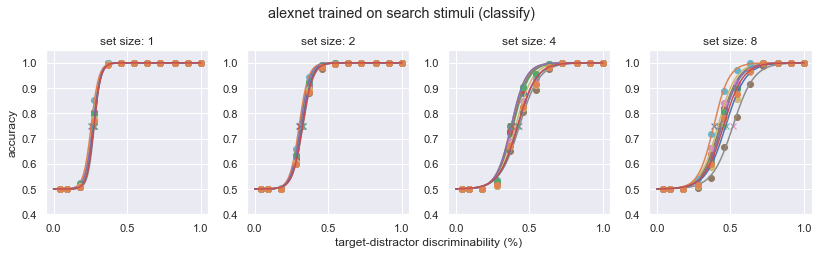

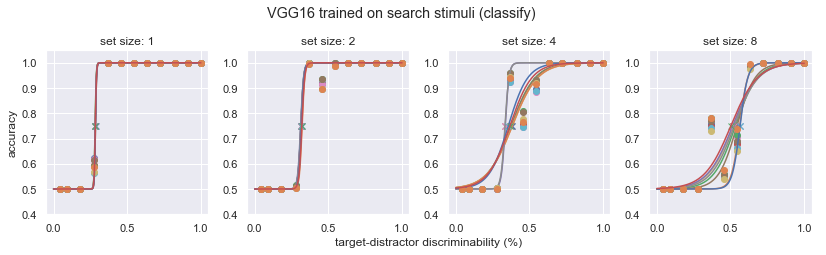

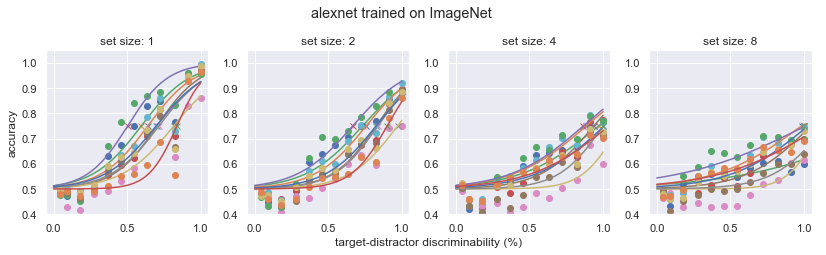

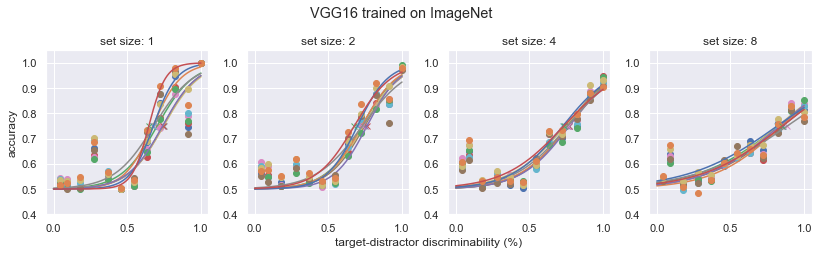

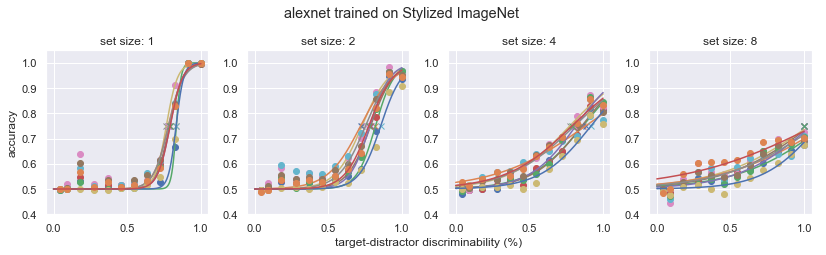

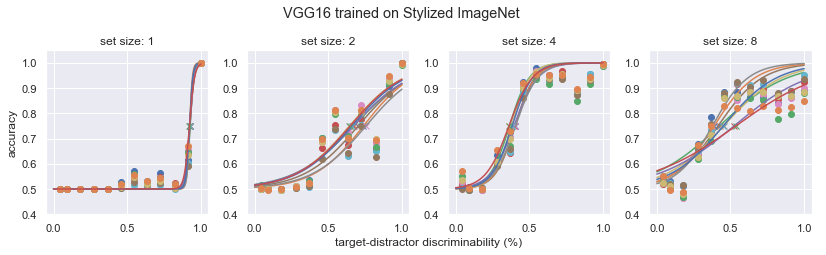

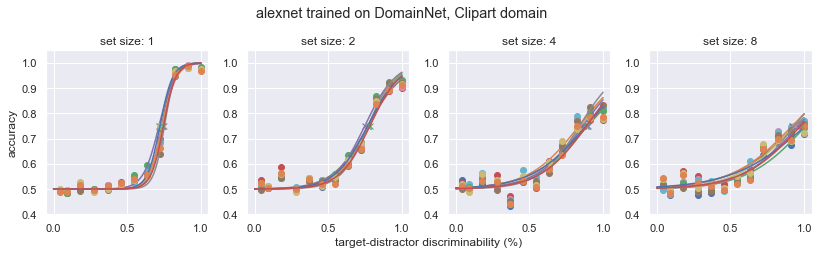

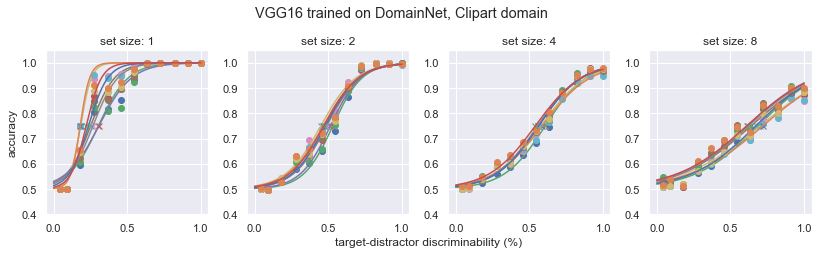

In [20]:
for source_dataset in SOURCE_DATASETS_TO_USE:
    for net_name in NET_NAMES:
        inspect_fits(fits_source_df=source_fits_dfs['tvt'],
                     fits_df=fits_dfs['tvt'],
                     net_name=net_name,
                     method='transfer',
                     source_dataset=source_dataset)

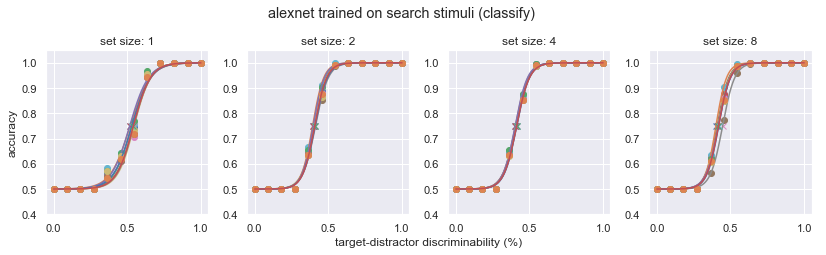

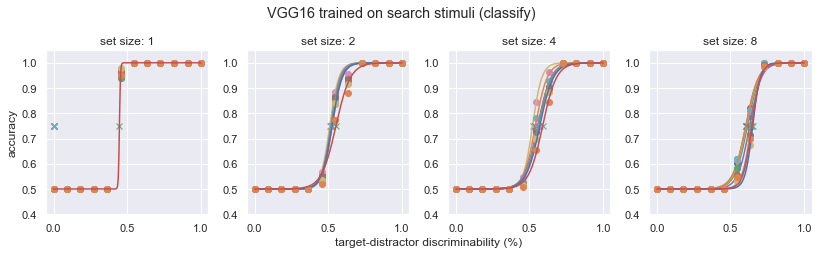

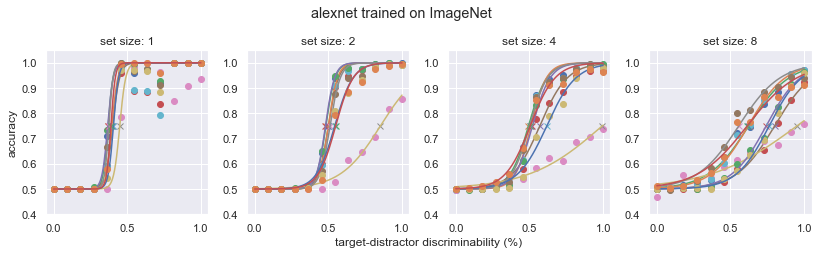

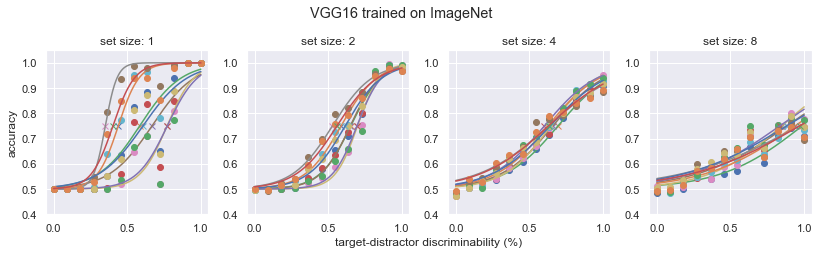

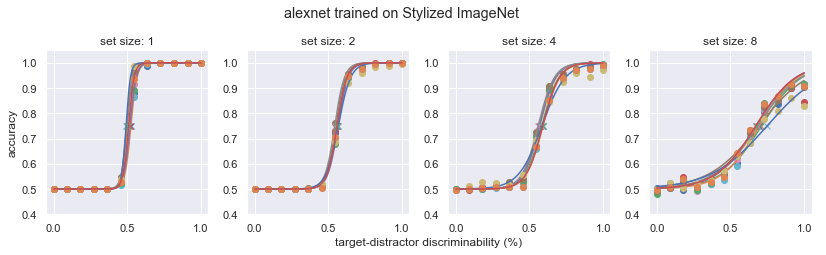

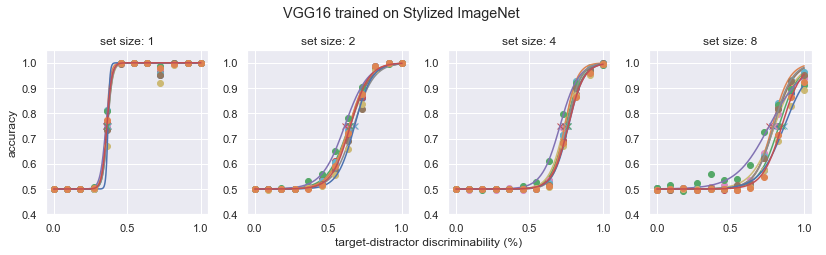

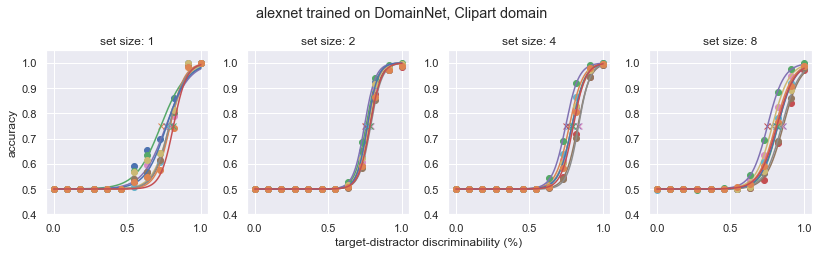

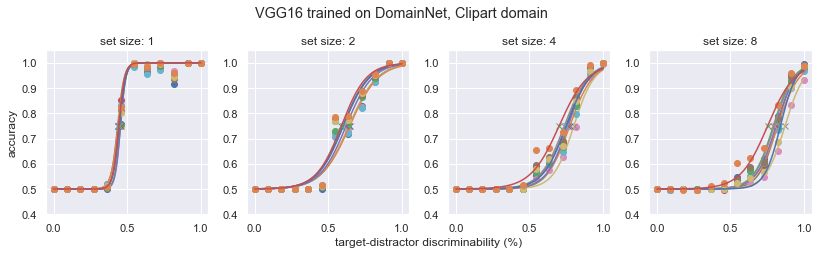

In [21]:
for source_dataset in SOURCE_DATASETS_TO_USE:
    for net_name in NET_NAMES:
        inspect_fits(fits_source_df=source_fits_dfs['rvg'],
                     fits_df=fits_dfs['rvg'],
                     net_name=net_name,
                     method='transfer',
                     source_dataset=source_dataset)

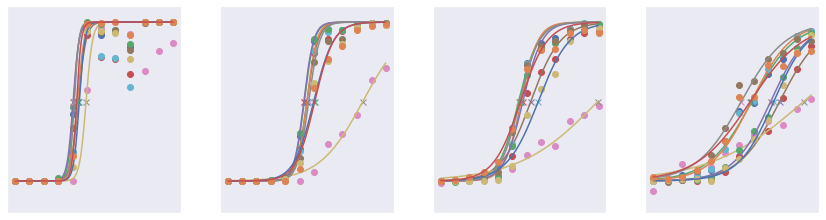

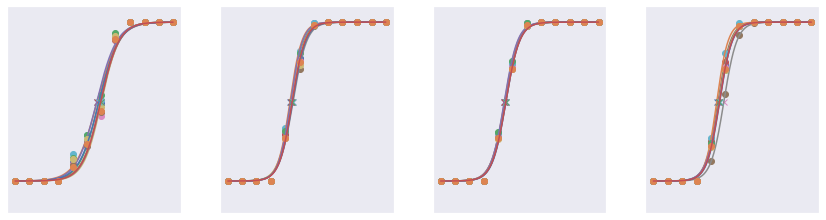

In [35]:
save_dst = 'docs/paper/figures/experiment-1/discriminability'


for source_dataset in (
    'ImageNet',
    'search stimuli (classify)',
):
    fig, suptitle = inspect_fits(fits_source_df=source_fits_dfs['rvg'],
                                 fits_df=fits_dfs['rvg'],
                                 net_name='alexnet',
                                 method='transfer',
                                 source_dataset=source_dataset,
                                 axes_title=False,
                                 suptitle=False,
                                 xylabel=False,
                                 figsize=(12, 3.5))
    for ax_ in fig.axes:
        ax_.set_xticks([])
        ax_.set_yticks([])
    
    for ext in ('svg', 'png'):
        source_dataset = source_dataset.replace(' ', '-')
        fig.savefig(pyprojroot.here() / save_dst / f'alexnet-{source_dataset}.{ext}')